**Feedforward Neural Network (FNN)**

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import random
import time
#from tqdm import tqdm, trange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import mlflow
from dotenv import load_dotenv

In [2]:
start_time = time.time()

Load csv into df

In [3]:
# --- Ensure consistent working directory for data loading ---
# This block dynamically sets the current working directory to the Git repository root.
# This makes data paths reliable for all collaborators, regardless of where they open the notebook.

current_dir = os.getcwd()
repo_root = current_dir
while not os.path.exists(os.path.join(repo_root, '.git')):
    # Move up one directory
    parent_dir = os.path.dirname(repo_root)
    if parent_dir == repo_root: # Reached filesystem root, .git not found
        raise FileNotFoundError(
            "Could not find the .git directory. "
            "Please ensure you are running this code from within a Git repository."
        )
    repo_root = parent_dir

# Change the current working directory if it's not already the repo root
if os.getcwd() != repo_root:
    os.chdir(repo_root)
    print(f"Working directory set to: {os.getcwd()}") # Informative print for users


# --- Data Loading ---
# Path to the data file, relative to the repository root.
data_file_name = 'Customer_Purchasing_Behaviors.csv'
data_file_path = os.path.join('data', 'raw', data_file_name)

try:
    df = pd.read_csv(data_file_path)
    print(f"Successfully loaded '{data_file_name}' into the DataFrame named df.")
    #print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{data_file_name}' was not found at '{data_file_path}'.")
    print("Please ensure it exists in the 'data/raw/' folder relative to the repository root.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Working directory set to: c:\Users\The Winner\DSI\customer_purchasing_behaviour
Successfully loaded 'Customer_Purchasing_Behaviors.csv' into the DataFrame named df.


Prepare data: scale numerical and encode categorical

In [4]:
# Preprocessing: Prepare Inputs

# Extract relevant columns
numerical_cols = ['age', 'annual_income', 'loyalty_score', 'purchase_frequency']
categorical_col = 'region'
target_col = 'purchase_amount'

# Scale numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numerical_cols])

# Encode categorical feature
encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(df[[categorical_col]])

# Create DataFrames with distinct column names
num_df = pd.DataFrame(X_num, columns=numerical_cols)
cat_columns = encoder.get_feature_names_out([categorical_col])
cat_df = pd.DataFrame(X_cat, columns=cat_columns)

# Combine safely
combined_df = pd.concat([num_df, cat_df], axis=1)

# Convert to torch tensor
X_combined = torch.tensor(combined_df.values, dtype=torch.float32)

# Target variable
y = torch.tensor(df[target_col].values, dtype=torch.float32).view(-1, 1)

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Split into Train + Validation, and Test (80% train+val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

2025/07/22 22:54:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training:   0%|          | 0/10001 [00:00<?, ?it/s]

Epoch 0:
Train → MSE = 204984.8125, RMSE = 452.7525, MAE = 433.7315, R² = -11.1192
Val   → MSE = 193116.9688, RMSE = 439.4507, MAE = 411.5416, R² = -7.1000
Epoch 10000:
Train → MSE = 93.6085, RMSE = 9.6752, MAE = 7.2229, R² = 0.9945
Val   → MSE = 97.7035, RMSE = 9.8845, MAE = 7.2163, R² = 0.9959
🔍 Minimum average loss before epoch 7500: 95.6427 at epoch 6362

Final Test Evaluation:
MSE = 120.3766, RMSE = 10.9716, MAE = 7.7399, R² Score = 0.9946


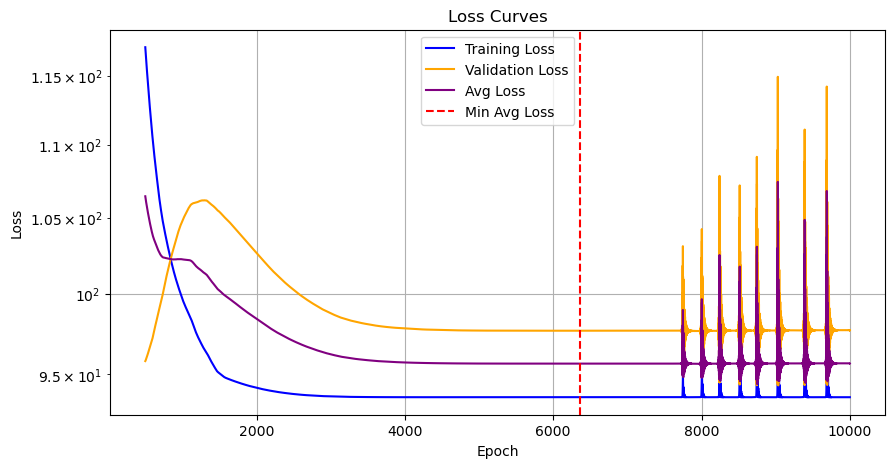

Run ID: b21043b79e904aed98b43a018fe2b5ce


In [ ]:
# load_dotenv()

# mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
# mlflow.set_experiment(os.getenv("MLFLOW_EXPERIMENT_NAME"))

# set the experiment_id

mlflow.set_experiment("Customer_spending_NN")

mlflow.autolog()

lr = 0.005
width_1st_layer = 64
width_2nd_layer = 32

params = {
    "lr": lr,
    "width_1st_layer": width_1st_layer,
    "width_2nd_layer": width_2nd_layer
}

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metric("test", 42)

    # Make it reproducible
    SEED = 42
    random.seed(SEED)                 # Python random
    np.random.seed(SEED)              # NumPy
    torch.manual_seed(SEED)           # CPU
    torch.cuda.manual_seed(SEED)      # GPU
    torch.cuda.manual_seed_all(SEED)  # Multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Define the Neural Network Model

    class FeedforwardNN(nn.Module):
        def __init__(self, input_size):
            super(FeedforwardNN, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_size, width_1st_layer),
                nn.ReLU(),
                nn.Linear(width_1st_layer, width_2nd_layer),
                nn.ReLU(),
                nn.Linear(width_2nd_layer, 1)
            )

        def forward(self, x):
            return self.layers(x)

    model = FeedforwardNN(input_size=X_train.shape[1])
    def init_weights(m):
        '''Make the weight initialization reproducible'''
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)  # still uses seed
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.01)
    model.apply(init_weights)      

    # Make GPU work
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = "cpu"
    # Move data to device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    # Move model to device
    model = model.to(device)

    # Training with MSE & Logging RMSE, MAE 

    # Metrics
    def compute_rmse(predictions, targets):
        return torch.sqrt(F.mse_loss(predictions, targets))
    def compute_mae(predictions, targets):
        return torch.mean(torch.abs(predictions - targets))
    def compute_r2(predictions, targets):
        ss_res = torch.sum((targets - predictions) ** 2)
        ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
        return 1 - ss_res / ss_tot

    # Training + Early Stopping
    criterion = nn.MSELoss()   # Mean Squared Error (MSE) loss
    optimizer = optim.Adam(model.parameters(), lr)
    best_val_loss = float('inf')
    patience = 500
    trigger_times = 0
    min_delta = -0.05
    train_losses = []
    val_losses = []


    progress = tqdm(range(10001), desc="Training")
    for epoch in progress:

            model.train()
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)      # MSE for optimization
            loss.backward()
            optimizer.step()

            # dinamically update
            rmse = compute_rmse(output, y_train)
            progress.set_postfix({"Loss": loss.item(), "RMSE": rmse.item()})

            # Validation step
            model.eval()
            with torch.no_grad():
                val_output = model(X_val)
                val_loss = criterion(val_output, y_val)
            
            # Save losses each epoch
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())

            # Early stopping logic
            if val_loss.item() + min_delta < best_val_loss:
                best_val_loss = val_loss.item()
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"\n⏹️ Early stopping at epoch {epoch} — no validation improvement after {patience} epochs.")
                    rmse = compute_rmse(output, y_train)
                    mae = compute_mae(output, y_train)
                    r2 = compute_r2(output, y_train)
                    val_rmse = compute_rmse(val_output, y_val)
                    val_mae = compute_mae(val_output, y_val)
                    val_r2 = compute_r2(val_output, y_val)
                    print(f"Train → MSE = {loss.item():.4f}, RMSE = {rmse.item():.4f}, MAE = {mae.item():.4f}, R² = {r2.item():.4f}")
                    print(f"Val   → MSE = {val_loss.item():.4f}, RMSE = {val_rmse.item():.4f}, MAE = {val_mae.item():.4f}, R² = {val_r2.item():.4f}")
                    break

            if epoch % 10000 == 0 or trigger_times == patience:
                rmse = compute_rmse(output, y_train)
                mae = compute_mae(output, y_train)
                r2 = compute_r2(output, y_train)
                val_rmse = compute_rmse(val_output, y_val)
                val_mae = compute_mae(val_output, y_val)
                val_r2 = compute_r2(val_output, y_val)
                print(f"Epoch {epoch}:")
                print(f"Train → MSE = {loss.item():.4f}, RMSE = {rmse.item():.4f}, MAE = {mae.item():.4f}, R² = {r2.item():.4f}")
                print(f"Val   → MSE = {val_loss.item():.4f}, RMSE = {val_rmse.item():.4f}, MAE = {val_mae.item():.4f}, R² = {val_r2.item():.4f}")

    # Compute average loss per epoch
    avg_losses = [(train + val) / 2 for train, val in zip(train_losses, val_losses)]
    # Condition to only search within epochs < 7500
    search_limit = 7500
    limited_avg_losses = avg_losses[:search_limit]
    # Find the minimum within this range
    min_avg = min(limited_avg_losses)
    epoch_min_avg = limited_avg_losses.index(min_avg)
    print(f"🔍 Minimum average loss before epoch 7500: {min_avg:.4f} at epoch {epoch_min_avg}")

    # Final Evaluation on Test Set
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        test_loss = criterion(predictions, y_test)
        test_rmse = compute_rmse(predictions, y_test)
        test_mae = compute_mae(predictions, y_test)
        test_r2 = compute_r2(predictions, y_test)
        print(f"\nFinal Test Evaluation:")
        print(f"MSE = {test_loss.item():.4f}, RMSE = {test_rmse.item():.4f}, MAE = {test_mae.item():.4f}, R² Score = {test_r2.item():.4f}")

    # Plot after training
    start = 500 
    plt.figure(figsize=(10, 5))
    plt.yscale('log')
    plt.plot(range(start, len(train_losses)), train_losses[start:], label='Training Loss', color='blue')
    plt.plot(range(start, len(val_losses)), val_losses[start:], label='Validation Loss', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    # Draw line minimum average training and validation losses
    plt.plot(range(start, len(avg_losses)), avg_losses[start:], label='Avg Loss', color='purple')
    plt.axvline(x=epoch_min_avg, color='red', linestyle='--', label='Min Avg Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print run info
    run = mlflow.active_run()
    print(f"Run ID: {run.info.run_id}")

    # Clean memory in case we want to run this cell again without running the whole notebook
    # remove references to GPU objects 
    del model
    # Invoke garbage collector
    gc.collect()
    # Clear GPU cache
    torch.cuda.empty_cache()

    # Final Test Evaluation:
    # MSE = 120.3766, RMSE = 10.9716, MAE = 7.7399

In [ ]:
# Make it reproducible

SEED = 42
random.seed(SEED)                 # Python random
np.random.seed(SEED)              # NumPy
torch.manual_seed(SEED)           # CPU
torch.cuda.manual_seed(SEED)      # GPU
torch.cuda.manual_seed_all(SEED)  # Multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the Neural Network Model

class FeedforwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedforwardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = FeedforwardNN(input_size=X_train.shape[1])
def init_weights(m):
    '''Make the weight initialization reproducible'''
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)  # still uses seed
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0.01)
model.apply(init_weights)      

# Make GPU work
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
# Move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
# Move model to device
model = model.to(device)

# Training with MSE & Logging RMSE, MAE 

# Metrics
def compute_rmse(predictions, targets):
    return torch.sqrt(F.mse_loss(predictions, targets))
def compute_mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets))
def compute_r2(predictions, targets):
    ss_res = torch.sum((targets - predictions) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
    return 1 - ss_res / ss_tot

# Training + Early Stopping
criterion = nn.MSELoss()   # Mean Squared Error (MSE) loss
optimizer = optim.Adam(model.parameters(), lr=0.005)
best_val_loss = float('inf')
patience = 500
trigger_times = 0
min_delta = -0.05
train_losses = []
val_losses = []


progress = tqdm(range(6362+1), desc="Training")
for epoch in progress:

        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)      # MSE for optimization
        loss.backward()
        optimizer.step()

        # dinamically update
        rmse = compute_rmse(output, y_train)
        progress.set_postfix({"Loss": loss.item(), "RMSE": rmse.item()})

        # Validation step
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
        
        # Save losses each epoch
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 10000 == 0 or trigger_times == patience:
            rmse = compute_rmse(output, y_train)
            mae = compute_mae(output, y_train)
            r2 = compute_r2(output, y_train)
            val_rmse = compute_rmse(val_output, y_val)
            val_mae = compute_mae(val_output, y_val)
            val_r2 = compute_r2(val_output, y_val)
            print(f"Epoch {epoch}:")
            print(f"Train → MSE = {loss.item():.4f}, RMSE = {rmse.item():.4f}, MAE = {mae.item():.4f}, R² = {r2.item():.4f}")
            print(f"Val   → MSE = {val_loss.item():.4f}, RMSE = {val_rmse.item():.4f}, MAE = {val_mae.item():.4f}, R² = {val_r2.item():.4f}")

# Compute average loss per epoch
avg_losses = [(train + val) / 2 for train, val in zip(train_losses, val_losses)]
# Condition to only search within epochs < 7500
search_limit = 7500
limited_avg_losses = avg_losses[:search_limit]
# Find the minimum within this range
min_avg = min(limited_avg_losses)
epoch_min_avg = limited_avg_losses.index(min_avg)
print(f"🔍 Minimum average loss before epoch 7500: {min_avg:.4f} at epoch {epoch_min_avg}")

# Final Evaluation on Test Set
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    test_rmse = compute_rmse(predictions, y_test)
    test_mae = compute_mae(predictions, y_test)
    test_r2 = compute_r2(predictions, y_test)
    print(f"\nFinal Test Evaluation:")
    print(f"MSE = {test_loss.item():.4f}, RMSE = {test_rmse.item():.4f}, MAE = {test_mae.item():.4f}, R² Score = {test_r2.item():.4f}")

# Plot after training
start = 500 
plt.figure(figsize=(10, 5))
plt.yscale('log')
plt.plot(range(start, len(train_losses)), train_losses[start:], label='Training Loss', color='blue')
plt.plot(range(start, len(val_losses)), val_losses[start:], label='Validation Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
# Draw line minimum average training and validation losses
plt.plot(range(start, len(avg_losses)), avg_losses[start:], label='Avg Loss', color='purple')
plt.axvline(x=epoch_min_avg, color='red', linestyle='--', label='Min Avg Loss')
plt.legend()
plt.grid(True)
plt.show()

# Clean memory in case we want to run this cell again without running the whole notebook
# remove references to GPU objects 
del model
# Invoke garbage collector
gc.collect()
# Clear GPU cache
torch.cuda.empty_cache()

# Final Test Evaluation:
# MSE = 120.3766, RMSE = 10.9716, MAE = 7.7399

In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n⏳ Training completed in {elapsed_time:.2f} seconds.")
# GPU: ⏳ Training completed in 16.07 seconds.
# CPU: ⏳ Training completed in 14.11 seconds.